# Opinion dynamics over discourse sheaves

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import null_space
from scipy.integrate import solve_ivp

## Constant sheaves with stalk equal to $\mathbb{R}^n$ on each vertex and node

### Opinion diffusion via Laplacian heat equation 

In [2]:
# Let's generate a toy topology for our example

nodes = [i for i in range(7)]
edges = [
    (0,1),
    (0,3),
    (0,6),
    (1,2),
    (1,5),
    (2,4),
    (4,6),
    (5,6)
]

V = 7
E = len(edges)

d = 3                                           # Node and edges stalks dimension

# Sheaf representation 

# Coboundary map

B = np.zeros((d*E, d*V))

for i in range(len(edges)):
    edge = edges[i]

    u = edge[0] 
    v = edge[1] 

    B[i*d:(i+1)*d, u*d:(u+1)*d] = np.ones((d,d))
    B[i*d:(i+1)*d, v*d:(v+1)*d] = np.ones((d,d))

# Sheaf Laplacian

L_f = B.T @ B

In [3]:
def privateOpinionDynamic(
        t, 
        x,
        L_f, 
        alpha
        ):
    
    return - alpha * L_f @ x

def privateOpinionDynamicSolver(
        L_f, 
        x0, 
        alpha = 0.05,
        T = 100,
        time_span = 100
        ):

    time_points = np.linspace(0, T, time_span)

    solution = solve_ivp(
        privateOpinionDynamic, 
        [0, 100], 
        x0, 
        t_eval=time_points, 
        args=(L_f, alpha),
        method='RK45'
        )
    
    trajectory = solution.y.T
    return trajectory, time_points

In [4]:
def nullSpaceProjection(L_f, x0):
    U = null_space(L_f)
    proj = U @ U.T
    
    return proj @ x0

In [5]:
x0 = np.random.randn(V*d)
X_hat, time_points = privateOpinionDynamicSolver(L_f, x0)
x_null = nullSpaceProjection(L_f, x0)

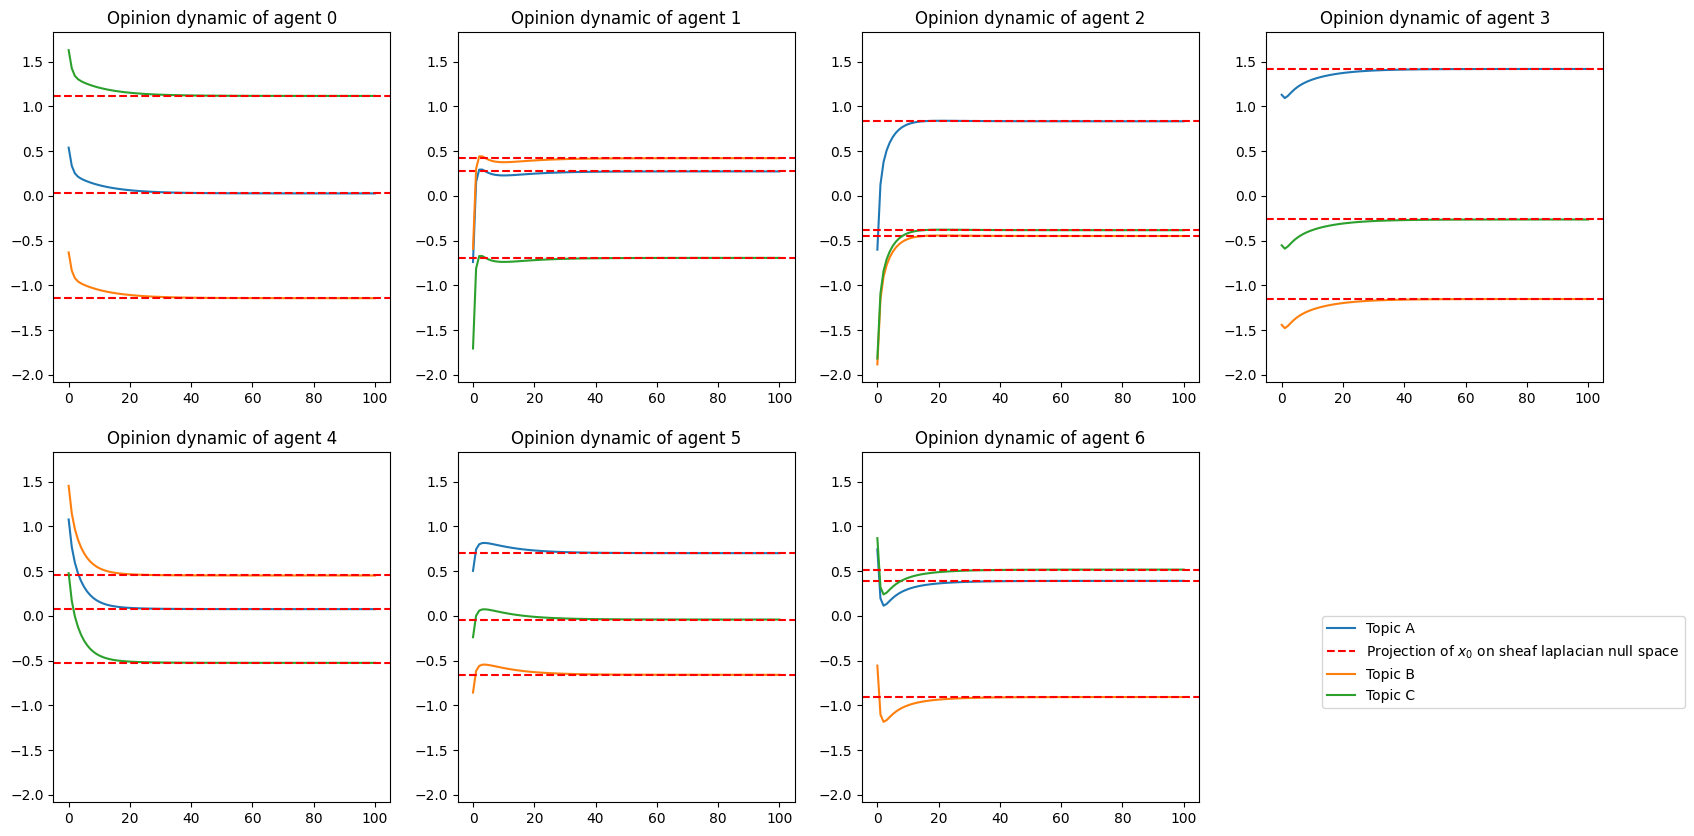

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

topics = {
    i:chr(65 + i) for i in range(d)
}

# Determine the global minimum and maximum y-values
y_min = float('inf')
y_max = float('-inf')

for i in range(V):
    for j in range(d):
        y_min = min(y_min, min(X_hat[:, i*d+j]), x_null[i*d+j])
        y_max = max(y_max, max(X_hat[:, i*d+j]), x_null[i*d+j])

y_min -= 0.2
y_max += 0.2

for i in range(V):
    ax = axs[i // 4, i % 4]
    for j in range(d):
        ax.plot(time_points, X_hat[:, i*d+j], label=f'Topic {topics[j]}')
        if j == 0:
            ax.axhline(y=x_null[i*d+j], color='r', linestyle='--', label='Projection of $x_0$ on sheaf laplacian null space')
        else:
            ax.axhline(y=x_null[i*d+j], color='r', linestyle='--')

        ax.set_title(f'Opinion dynamic of agent {i}')
    
    ax.set_ylim(y_min, y_max)  # Set the same y-axis limits for all subplots

axs[-1, -1].axis('off')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.85, 0.25))

plt.show()


### Modeling stubborn agents requires just restriction on the dynamics

In [7]:
def stubbornAgentsOpinionDynamic(
        t, 
        x,
        PU,
        L_f, 
        alpha
        ):
    
    return - alpha * PU * (L_f @ x)

def stubbornAgentsOpinionDynamicSolver(
        L_f, 
        x0, 
        U,
        d,
        alpha = 0.05,
        T = 100,
        time_span = 100
        ):

    time_points = np.linspace(0, T, time_span)

    # Mask for the stubborn agents

    PU = np.ones_like(x0)
    for i in U:
        PU[i*d:(i+1)*d] = 0

    solution = solve_ivp(
        stubbornAgentsOpinionDynamic, 
        [0, 100], 
        x0, 
        t_eval=time_points, 
        args=(PU, L_f, alpha),
        method='RK45'
        )
    
    trajectory = solution.y.T
    return trajectory, time_points

In [8]:
x0 = np.random.randn(V*d)
U = np.random.choice(V, 2, replace=False)
X_hat, time_points = stubbornAgentsOpinionDynamicSolver(L_f, x0, U, d)

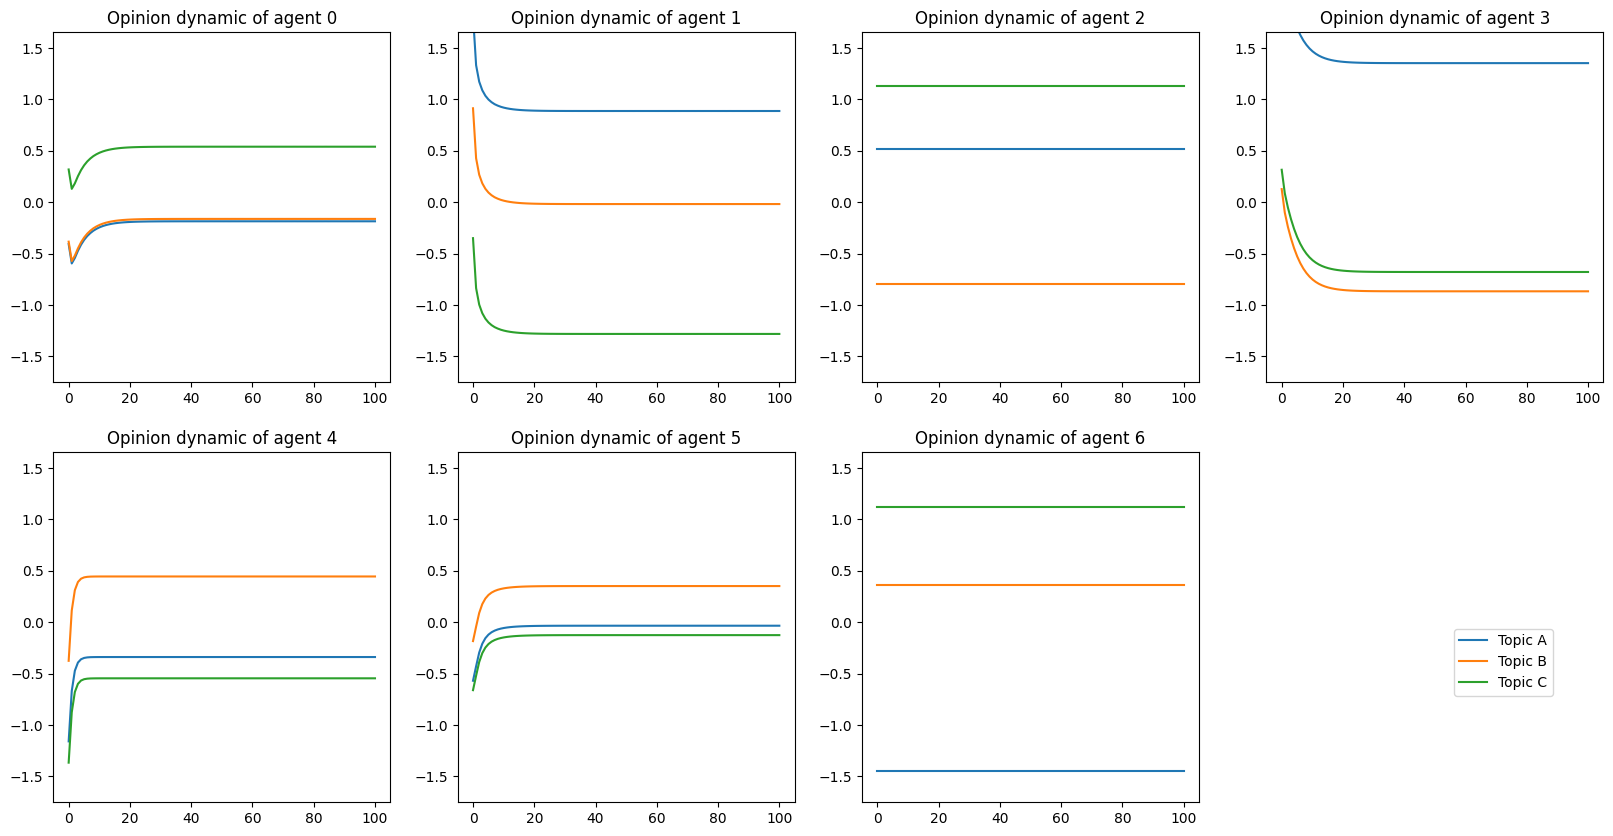

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

topics = {
    i:chr(65 + i) for i in range(d)
}
# Determine the global minimum and maximum y-values
y_min = float('inf')
y_max = float('-inf')

for i in range(V):
    for j in range(d):
        y_min = min(y_min, min(X_hat[:, i*d+j]))
        y_max = max(y_max, min(X_hat[:, i*d+j]))

y_min -= 0.3
y_max += 0.3

for i in range(V):
    ax = axs[i // 4, i % 4]
    for j in range(d):
        ax.plot(time_points, X_hat[:, i*d+j], label=f'Topic {topics[j]}')

        ax.set_title(f'Opinion dynamic of agent {i}')
    
    ax.set_ylim(y_min, y_max)  # Set the same y-axis limits for all subplots

axs[-1, -1].axis('off')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.85, 0.25))

plt.show()

### Expression diffusion for "learning to lie" dynamics

In [10]:
# Let's generate a toy topology for our example

nodes = [i for i in range(7)]
edges = [
    (0,1),
    (0,3),
    (0,6),
    (1,2),
    (1,5),
    (2,4),
    (4,6),
    (5,6)
]

V = 7
E = len(edges)

d = 1                                           # Node and edges stalks dimension

F = {
    e:{
        e[0]:np.random.randn(d,d),
        e[1]:np.random.randn(d,d)
        } 
        for e in edges
    }                                           # Incidency linear maps

# Sheaf representation 

# Coboundary map

B = np.zeros((d*E, d*V))

for i in range(len(edges)):
    edge = edges[i]

    u = edge[0] 
    v = edge[1] 

    B_u = F[edge][u]
    B_v = F[edge][v]

    B[i*d:(i+1)*d, u*d:(u+1)*d] = np.ones((d,d))
    B[i*d:(i+1)*d, v*d:(v+1)*d] = - np.ones((d,d))

# Sheaf Laplacian

L_f = B.T @ B

In [11]:
def expressionDynamic(
        t, 
        B_flatten, 
        P,
        E,
        V, 
        d, 
        beta, 
        x0
        ):
    
    B = B_flatten.reshape(E*d,V*d)
    dt_dB = (- beta * P * (B @ np.outer(x0, x0)))
    return dt_dB.flatten()

def expressionDynamicSolver(
        B0, 
        x0, 
        E,
        V,
        d,
        beta = 0.1,
        T = 100,
        time_span = 100
        ):

    time_points = np.linspace(0, T, time_span)

    # Projector to preserve coboundary map sparsity structure
    P = (B0 != 0).astype('int32')

    solution = solve_ivp(
        expressionDynamic, 
        [0, 100], 
        B0.flatten(), 
        t_eval=time_points, 
        args=(P, E, V, d, beta, x0,),
        method='RK45'
        )
    
    B_hat = solution.y[:,-1].reshape(E*d, V*d)
    
    # Tracker of the disagreement 
    Bs = solution.y.T.reshape(time_points.shape[0], E*d, V*d)
    disagreement = x0.T @ (Bs.transpose(0,2,1) @ Bs.transpose(0,1,2)) @ x0

    return B_hat, disagreement

In [12]:
B0 = np.copy(B)
x0 = np.random.randn(V*d)

B_hat, disagreement = expressionDynamicSolver(B0, x0, E, V, d)

In [13]:
B_hat

array([[-0.20689489, -0.51730251,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.04015208,  0.        ,  0.        , -0.95631108,  0.        ,
         0.        ,  0.        ],
       [-0.09380582,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.11608374],
       [ 0.        ,  1.17264167, -0.71804148,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.19783505,  0.        ,  0.        ,  0.        ,
        -0.38587234,  0.        ],
       [ 0.        ,  0.        , -0.18301143,  0.        , -0.67988674,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.74561657,
         0.        ,  0.16305381],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.75610159, -1.15875187]])

In [14]:
L_hat = B_hat.T @ B_hat

In [15]:
x0.T @ L_f @ x0

12.335495181140994

In [16]:
x0.T @ L_hat @ x0

9.399898671483796e-06

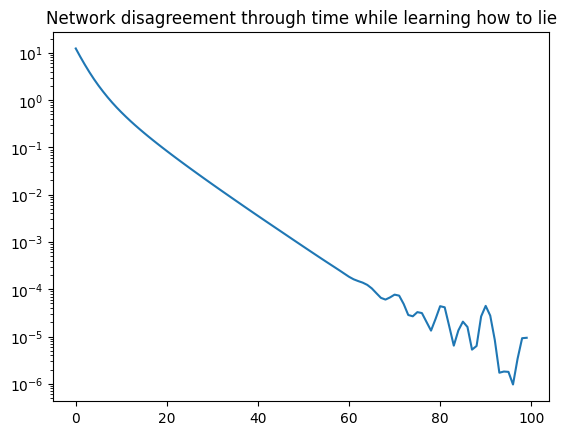

In [17]:
plt.plot(disagreement)
plt.title('Network disagreement through time while learning how to lie')
plt.yscale('log')